In [ ]:
!pip install num2words
!pip install emoji

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 15.5 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=ea7bc0c57eaa2867ac387dd59a6a5cf0cadda079f836cd76979ca5b6416e4ba0
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 28.7 MB/s eta 0:00:00


In [ ]:
import re, random
import numpy as np
import nltk
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

from sklearn.metrics import recall_score, cohen_kappa_score, accuracy_score, log_loss
from sklearn.preprocessing import label_binarize
import math

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from num2words import num2words
import emoji

nltk.download('stopwords')
MODEL_NAME = "xlm-roberta-base"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)



--- RUNNING HYPOTHESIS TEST 1: Untrained Embedding Analysis on Urdu ---
Loading Target Data (Urdu) for zero-shot check...
Loading raw XLM-R...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Extracting embeddings...
Calculating t-SNE...
Saved plot to 'hypothesis_urdu_untrained.png'
--- TEST 1 COMPLETE ---



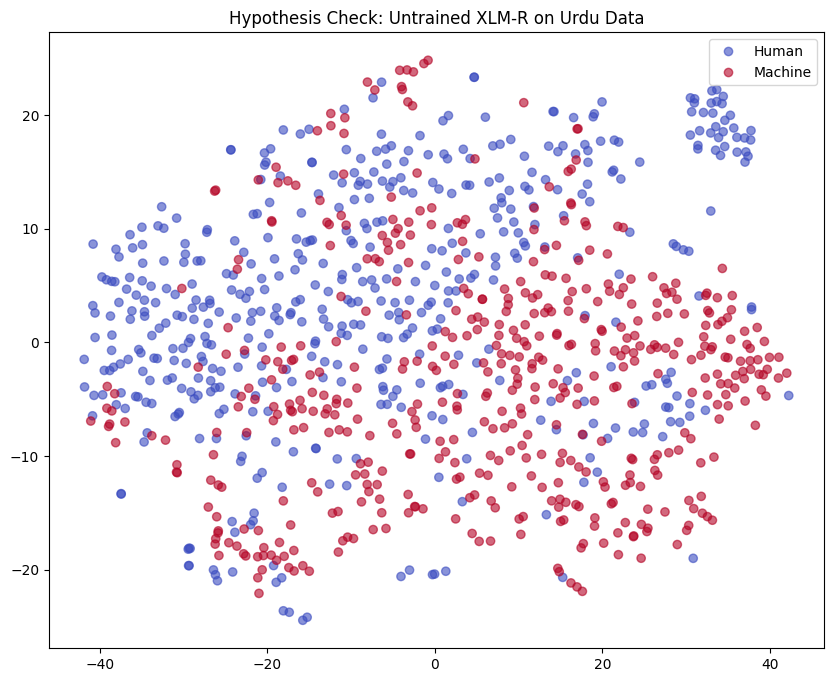

In [ ]:
# ==================================================================================
# HYPOTHESIS TEST 1: Zero-Shot Check on URDU (Target) - Before Training
# Purpose: Check if untrained XLM-R already separates Urdu Human/Machine text.
# ==================================================================================
print("\n--- RUNNING HYPOTHESIS TEST 1: Untrained Embedding Analysis on Urdu ---")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Load the TARGET Data (Urdu)
# Note: Defining a temporary simple cleaner since the main one isn't defined yet
def temp_clean_urdu(text):
    text = str(text).strip()
    text = re.sub(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+', ' ', text)
    return text

print("Loading Target Data (Urdu) for zero-shot check...")
# Assuming 'urdu_train.csv' is your Urdu file based on previous chats
df_target = pd.read_csv('urdu_train.csv')
# df_target = df_target.drop(columns=['id']) # Uncomment if your urdu file has an ID column
# Ensure labels are 0 and 1. If urdu_train.csv uses "human"/"machine" strings, map them:
if df_target['label'].dtype == object:
    df_target["label"] = df_target["label"].map({"human": 0, "machine": 1})

# Sample 500 from each class for the plot
df_h = df_target[df_target['label']==0].sample(n=500, random_state=42)
df_m = df_target[df_target['label']==1].sample(n=500, random_state=42)
df_viz = pd.concat([df_h, df_m]).reset_index(drop=True)

# 2. Load Raw Model
print("Loading raw XLM-R...")
temp_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
temp_model = AutoModel.from_pretrained(MODEL_NAME).to(torch.device("cuda"))
temp_model.eval()

# 3. Extract Embeddings
print("Extracting embeddings...")
embeddings = []
labels_viz = df_viz['label'].tolist()
texts_viz = df_viz['text'].astype(str).apply(temp_clean_urdu).tolist() # Assuming column name is 'text' for Urdu

batch_size_viz = 32
with torch.no_grad():
    for i in range(0, len(texts_viz), batch_size_viz):
        batch_txt = texts_viz[i:i+batch_size_viz]
        inputs = temp_tokenizer(batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=128).to(torch.device("cuda"))
        outputs = temp_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

X_viz = np.vstack(embeddings)

# 4. t-SNE & Plot
print("Calculating t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_viz)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_viz, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Human', 'Machine'])
plt.title("Hypothesis Check: Untrained XLM-R on Urdu Data")
plt.savefig("hypothesis_urdu_untrained.png")
print("Saved plot to 'hypothesis_urdu_untrained.png'")
print("--- TEST 1 COMPLETE ---\n")
# ==================================================================================

In [ ]:
df = pd.read_csv('ground_truth.csv')
df = df.drop(columns=['id'])

label_map = {"human": 0, "machine": 1}
df["label"] = df["label"].map(label_map)

stopwords_arabic = set(stopwords.words('arabic'))

# Arabic Text Cleaning Functions
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def normalize_urdu(text):
    text = text.replace('ی', 'ی')
    text = text.replace('ء', '')
    text = text.replace('ئ', 'ی')
    text = text.replace('ة', 'ہ')
    text = text.replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا')
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)


def clean_text(text):
    text = str(text).strip()
    text = remove_emojis(text)
    text = remove_urls_handles(text)
    text = normalize_arabic(text)
    text = remove_tatweel(text)
    text = normalize_whitespace(text)
    return text



cleaned_texts = df["content"].astype(str).apply(clean_text).tolist()
labels = torch.tensor(df['label'].values, dtype=torch.long)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

In [ ]:
# Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

for param in model.bert.embeddings.parameters():
    param.requires_grad = False
N_FREEZE = 6
for layer in model.bert.encoder.layer[:N_FREEZE]:
    for param in layer.parameters():
        param.requires_grad = False

for epoch in range(5):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == batch_labels).sum().item()
        train_total += batch_labels.size(0)

    train_acc = train_correct / train_total

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")


/tmp/ipython-input-3743962911.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch 1 | Train Loss: 64.3354 | Train Acc: 0.8031
Epoch 2 | Train Loss: 18.9197 | Train Acc: 0.9681
Epoch 3 | Train Loss: 13.4506 | Train Acc: 0.9768
Epoch 4 | Train Loss: 9.4323 | Train Acc: 0.9809
Epoch 5 | Train Loss: 6.1730 | Train Acc: 0.9889


In [ ]:
# Testing on a different dataset

In [ ]:
class InferenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=max_length
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item


In [ ]:
test_urdu = pd.read_csv("urdu_train.csv")
test_urdu = test_urdu.sample(frac=1, random_state=42).reset_index(drop=True)

def clean_text(text):
    text = str(text).strip()
    text = remove_emojis(text)
    text = remove_urls_handles(text)
    text = remove_tatweel(text)
    text = normalize_urdu(text)
    text = normalize_whitespace(text)
    return text

urdu_dataset = InferenceDataset(
    texts=test_urdu["text"].astype(str).apply(clean_text).tolist(),
    labels=test_urdu["label"].values,
    tokenizer=tokenizer
)

urdu_loader = DataLoader(
    urdu_dataset,
    batch_size=32,
    shuffle=False
)

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in urdu_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        batch_preds = torch.argmax(outputs, dim=1)

        preds.extend(batch_preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [ ]:
print("Classification Report:")
print(classification_report(
    true_labels,
    preds,
    target_names=["human", "machine"],
    digits=3
))

preds_np = np.array(preds)
true_np = np.array(true_labels)

macro_f1 = f1_score(true_np, preds_np, average="macro")
macro_recall = recall_score(true_np, preds_np, average="macro")
print(f"\nMacro F1: {macro_f1:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

report_dict = classification_report(true_np, preds_np, output_dict=True)
# Map numeric keys to label names
label_map_rev = {0: "human", 1: "machine"}
per_class_f1 = [report_dict[str(k)]["f1-score"] for k in [0,1]]
f1_variance = np.var(per_class_f1)
print(f"\n\nPer-class F1: {per_class_f1}")
print(f"F1 Variance: {f1_variance:.6f}")

kappa = cohen_kappa_score(true_np, preds_np)
print(f"\n\nCohen's Kappa: {kappa:.4f}")

# Need probabilities from softmax
probs = []
with torch.no_grad():
    for batch in urdu_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids, attention_mask)
        prob_batch = torch.softmax(outputs, dim=1).cpu().numpy()
        probs.extend(prob_batch)
probs = np.array(probs)
# Brier score for binary
brier = np.mean((probs[:,1] - true_np) ** 2)
print(f"\n\nBrier Score: {brier:.6f}")

def compute_ece(probs, labels, n_bins=10):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_lower, bin_upper = bin_edges[i], bin_edges[i+1]
        mask = (probs[:,1] > bin_lower) & (probs[:,1] <= bin_upper)
        if np.any(mask):
            bin_conf = np.mean(probs[:,1][mask])
            bin_acc = np.mean(labels[mask])
            ece += (np.sum(mask)/len(labels)) * abs(bin_conf - bin_acc)
    return ece

ece = compute_ece(probs, true_np)
print(f"\n\nExpected Calibration Error (ECE): {ece:.6f}")

cm = confusion_matrix(true_np, preds_np)
print("\n\nConfusion Matrix:\n", cm)

# Confusion entropy per class
def confusion_entropy(cm):
    entropies = []
    for i in range(len(cm)):
        row = cm[i]
        probs_row = row / row.sum() if row.sum() > 0 else np.zeros_like(row)
        entropy = -np.sum([p*math.log2(p) for p in probs_row if p > 0])
        entropies.append(entropy)
    return entropies

entropies = confusion_entropy(cm)
print(f"Confusion Entropy per class: {entropies}")

acc = accuracy_score(true_np, preds_np)
print(f"\n\nAccuracy: {acc:.4f}")

Classification Report:
              precision    recall  f1-score   support

       human      0.662     0.410     0.507      5955
     machine      0.573     0.791     0.664      5955

    accuracy                          0.601     11910
   macro avg      0.618     0.601     0.585     11910
weighted avg      0.618     0.601     0.585     11910


Macro F1: 0.5855
Macro Recall: 0.6005


Per-class F1: [0.5065339141257, 0.6644096487515869]
F1 Variance: 0.006231


Cohen's Kappa: 0.2010


Brier Score: 0.332127


Expected Calibration Error (ECE): 0.303214


Confusion Matrix:
 [[2442 3513]
 [1245 4710]]
Confusion Entropy per class: [np.float64(0.9765401311539232), np.float64(0.7396974944886363)]


Accuracy: 0.6005



--- RUNNING HYPOTHESIS TEST 2: Arabic-Trained Model on Urdu ---
Extracting embeddings from TRAINED model...
Calculating t-SNE...
Saved plot to 'hypothesis_urdu_TRAINED.png'
--- TEST 2 COMPLETE ---


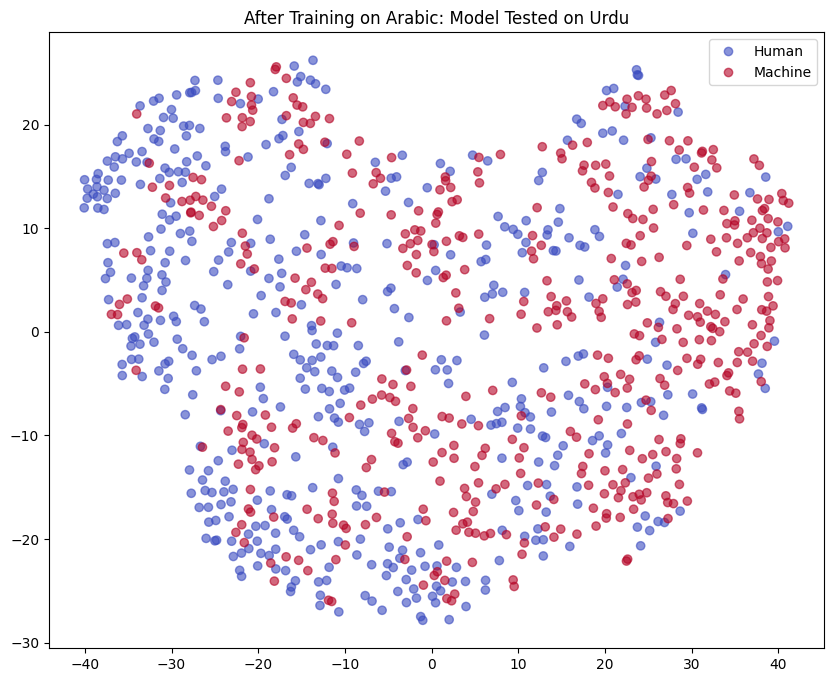

In [ ]:
# ==================================================================================
# HYPOTHESIS TEST 2: Trained Embedding Analysis on Urdu
# Purpose: Did learning Arabic help the model organize Urdu?
# ==================================================================================
print("\n--- RUNNING HYPOTHESIS TEST 2: Arabic-Trained Model on Urdu ---")

# 1. Re-load the Urdu Data
df_target_after = pd.read_csv('urdu_train.csv')
if df_target_after['label'].dtype == object:
    df_target_after["label"] = df_target_after["label"].map({"human": 0, "machine": 1})

df_h = df_target_after[df_target_after['label']==0].sample(n=500, random_state=42)
df_m = df_target_after[df_target_after['label']==1].sample(n=500, random_state=42)
df_viz_after = pd.concat([df_h, df_m]).reset_index(drop=True)

# 2. Extract Embeddings using TRAINED model
print("Extracting embeddings from TRAINED model...")
embeddings_after = []
labels_after = df_viz_after['label'].tolist()
texts_after = df_viz_after['text'].astype(str).apply(clean_text).tolist() # Use the main clean_text function

model.eval()

with torch.no_grad():
    for i in range(0, len(texts_after), batch_size_viz):
        batch_txt = texts_after[i:i+batch_size_viz]
        inputs = tokenizer(batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        # Access .bert to get raw embeddings, ignoring the classifier head
        outputs = model.bert(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        embeddings_after.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

X_viz_after = np.vstack(embeddings_after)

# 3. t-SNE & Plot
print("Calculating t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded_after = tsne.fit_transform(X_viz_after)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded_after[:, 0], X_embedded_after[:, 1], c=labels_after, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Human', 'Machine'])
plt.title("After Training on Arabic: Model Tested on Urdu")
plt.savefig("hypothesis_urdu_TRAINED.png")
print("Saved plot to 'hypothesis_urdu_TRAINED.png'")
print("--- TEST 2 COMPLETE ---")